In [1]:
import torch  # Основная библиотека для научных вычислений в PyTorch.
import torchvision  # Библиотека для работы с наборами данных, моделями и предварительно обученными моделями для компьютерного зрения.
import torchvision.transforms as transforms  # Модуль для преобразования изображений и данных.
from torch.utils.tensorboard import SummaryWriter  # Для визуализации обучения в TensorBoard.
import torch.optim as optim  # Оптимизаторы для PyTorch, например, SGD, Adam и другие.
from tqdm.notebook import tqdm  # Прогресс-бар для итераций и циклов в Jupyter Notebook.
import shutil  # Утилиты для операций с файлами и директориями в Python.
import cv2  # OpenCV - библиотека компьютерного зрения для обработки изображений и видео.
from torch import nn  # Модуль нейронных сетей PyTorch, предоставляющий базовые классы для создания архитектур нейронных сетей.
from torchvision.transforms import ToTensor  # Конвертация изображений в тензоры PyTorch.
from matplotlib import pyplot as plt  # Библиотека для визуализации данных, в частности, графиков и изображений.
import numpy as np  # Библиотека для работы с многомерными массивами данных.

import torch.nn.functional as F

# Cuda


In [2]:
import os

# Установите значение переменной окружения CUDA_HOME
os.environ['CUDA_HOME'] = "C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.3"

In [3]:
print(os.environ['CUDA_HOME'])

C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.3


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)  # Это выведет версию PyTorch, которую вы установили
print(torch.cuda.is_available())  # Это проверит доступность GPU

2.1.2+cu118
True


# Код

In [5]:
std_norm = [0.247, 0.243, 0.261]
mean_norm = [0.4914, 0.4822, 0.4465]

In [6]:
transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize(mean_norm, std_norm)
        ]
    )

In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss, train_accuracy = 0, 0
    model.train()
    with tqdm(dataloader, unit='batch') as tepoch:
        for images, labels in tepoch:

            # Определяем описание для tqdm
            tepoch.set_description(f'Epoch {epoch_n}')

            images, labels = images.to(device), labels.to(device)
            # Делаем forward pass
            pred = model(images)
            # вычисляем loss
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # Делаем шаг оптимизатора
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / images.shape[0]

            # Прибавляем loss и accuracy к полным значениям за эпоху
            train_loss += loss.item()
            train_accuracy += correct
            # Выводим в tqdm текущие лосс и точность
            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

    # вычисляем среднее
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    # Записываем в тензорборд
    summary_writer.add_scalar(
        'train/loss',
        train_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'train/accuracy',
        train_accuracy,
        epoch_n
    )

In [9]:
def test_loop(dataloader, model, loss_fn, epoch_n,  device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    # На этапе валидации нам не нужно вычислять градиенты
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    summary_writer.add_scalar(
        'test/loss',
        test_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'test/accuracy',
        correct,
        epoch_n
    )
    print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

In [60]:
class MyNet(nn.Module):
    def __init__(self, in_channels: int = 3, num_of_classes: int = 10):
        super(MyNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            # Слой 1
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Слой 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Слой 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Слой 4
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1024, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=2048, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=2048, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=2048, out_features=num_of_classes),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [11]:
num_of_epochs = 10
batch_size = 32

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [61]:
net = MyNet()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

shutil.rmtree('runs/mynet', ignore_errors=True)
writer = SummaryWriter('runs/mynet')
for epoch_n in range(num_of_epochs):
    train_loop(trainloader, net, criterion, optimizer, epoch_n, device, writer)
    test_loop(testloader, net, criterion, epoch_n, device, writer)
print("Done!")

  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.622, Avg loss: 1.110580 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.724, Avg loss: 0.826486 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.764, Avg loss: 0.708312 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.785, Avg loss: 0.627023 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.812, Avg loss: 0.556296 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.815, Avg loss: 0.565360 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.819, Avg loss: 0.554443 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.818, Avg loss: 0.599330 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.827, Avg loss: 0.548155 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.832, Avg loss: 0.610707 

Done!


In [62]:
torch.save(net.state_dict(), 'model_weights.pth')

In [63]:
torch.save(net, 'model.pth')

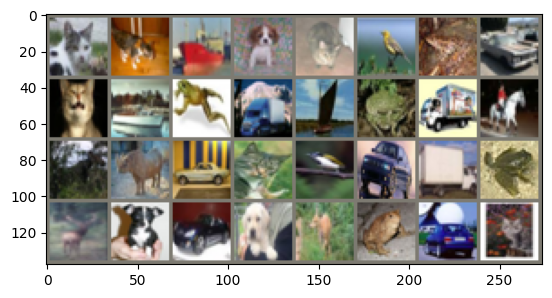

cat   cat   ship  dog   cat   bird  frog  car   cat   ship  frog  truck ship  frog  truck horse deer  deer  car   cat   bird  car   truck frog  deer  dog   car   dog   deer  frog  car   cat  


In [ ]:
def imshow(img):
    # Преобразование std и mean на устройстве cuda:0
    std = torch.tensor(std_norm, device=device, dtype=torch.float32)[:, None, None]
    mean = torch.tensor(mean_norm, device=device, dtype=torch.float32)[:, None, None]
    
    # Преобразование с перемещением std и mean на устройство cuda:0
    img = img * std + mean   # unnormalize
    
    # Переместите изображение обратно на CPU для отображения
    npimg = np.clip(img.cpu().numpy(), 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Получите некоторые случайные изображения из trainloader
images, labels = next(iter(trainloader))

# Переместите изображения и метки на устройство CUDA
images = images.to(device)
labels = labels.to(device)

# Покажите изображения
imshow(torchvision.utils.make_grid(images))  # Переместите изображения обратно на CPU для отображения

# Выведите метки
print(' '.join(f'{classes[labels[j].item()]:5s}' for j in range(batch_size)))

In [46]:
%load_ext tensorboard

%tensorboard --logdir runs/lenet

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14048), started 5 days, 10:19:34 ago. (Use '!kill 14048' to kill it.)